In [1]:
import os
import pandas as pd

import sys; sys.path.append("..") # Adds parent directory to python modules path.
from topdown_parsers import *

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import geopandas as gpd
from sklearn.linear_model import LinearRegression

from ER_noise import *

In [2]:
five_counties_dir = "five_counties_er_csvs"
# csv_dir_without_hhs = "er_csvs/runs_without_hhs"
# csv_dir_with_hhs = "er_csvs/runs_with_hhs"
# csv_dir_without_hhs = "er_csvs/gaussian_runs_without_hh"

epsilon_values = ["1"]
# epsilon_splits = ["equal", "bottom-heavy", "mid-heavy", "top-heavy"]
epsilon_splits = ["equal"]

In [3]:
# runoff_filepath = "DallasCounty_elects.csv"
runoff_filepath = "TX_statewide_18_Dem_Runofff.csv"
runoff_file = pd.read_csv(runoff_filepath)

# runoff_file["President_12G_ObamaD_pct"] = runoff_file["President_12G_ObamaD"] / runoff_file["President_12G_Total"]
# runoff_file["President_12G_ObamaD_pct"] = runoff_file["President_12G_ObamaD_pct"].fillna(0)

# runoff_file["Comptroller_18G_ChevalierD_pct"] = runoff_file["Comptroller_18G_ChevalierD"] / runoff_file["Comptroller_18G_Total"]
# runoff_file["Comptroller_18G_ChevalierD_pct"] = runoff_file["Comptroller_18G_ChevalierD_pct"].fillna(0)

In [4]:
obama = {
    "name"          : "Obama",
    "election_name" : "2012 General Presidential",
    "perc_col"      : "President_12G_ObamaD_pct",
    "tot_votes"     : "President_12G_Total"
    
}

valdez = {
    "name"          : "Valdez",
    "election_name" : "TX Statewide 2018 Dem Runoff Governor",
    "perc_col"      : "ValdezD_18R_Governor_pct",
    "tot_votes"     : "18R_Governor_D_tot" 
}

chevalier = {
    "name"          : "Chevalier",
    "election_name" : "Comptroller 2018 General",
    "perc_col"      : "Comptroller_18G_ChevalierD_pct",
    "tot_votes"     : "Comptroller_18G_ChevalierD"
}

# candidate_configs = [valdez, obama, chevalier]
candidate_configs = [valdez]

In [7]:
def plot_er_and_point_estimates(county, df, epsilon_values, epsilon_splits, race, candidate_configs, with_hh=False, fig_size=(20,20)):
    """
    """
    save_hh_str = "with_hh" if with_hh else "without_hh"
    title_hh_str = "with HH constraints" if with_hh else "without HH constraints"
    
#     sigma_matches = pd.read_csv("topdown_expected_l1_error_pcts_recon_and_matching_sigma.csv")
#     sigma_matches["sigma"] = sigma_matches["sigma"]
    
#     # gaussian 
#     for candidate in candidate_configs:
#         print(candidate["name"])
#         plot_elect_grid_gaussian_noise(epsilon_values, 
#                                        epsilon_splits, 
#                                        df, 
#                                        candidate["name"], 
#                                        race, 
#                                        candidate["perc_col"],
#                                        candidate["tot_votes"],
#                                        sigma_matches, 
#                                        hh=with_hh, 
#                                        figsize=(20,20), 
#                                        filt=True,
#                                        title=None, 
#                                        weight=False, 
#                                        n_samps=20)
        
#     return

    
    # configs
#     settings = ["weight", "filter", "no_filter"]
    settings = ["no_filter"]
    
    for candidate in candidate_configs:
        for sett in settings:
            if sett == "weight":
                title_sett_str = "weighted"; save_sett_str = "weighted"; weight = True; filt = False
            elif sett == "filter":
                title_sett_str = "filter at thresh=10"; save_sett_str = "filt_10"; weight = False; filt = True
            else:
                title_sett_str = "no_filter"; save_sett_str = "no_filt"; weight = False; filt = False
            
#             if not (len(epsilon_splits) == 1 and len(epsilon_values) == 1):
#                 er_title = "{} ER: Votes for {}: {} | TopDown Noise with {}, {}".format(county + " City",
#                                                               candidate["name"], 
#                                                               candidate["election_name"],
#                                                               title_sett_str, 
#                                                               title_hh_str)
#                 point_estimates_title = "{} Point Estimates: Votes for {}: {} | TopDown Noise with {}, {}".format(county + " City",
#                                                                            candidate["name"], 
#                                                                            candidate["election_name"],
#                                                                            title_sett_str, 
#                                                                            title_hh_str)
#             else:
            er_title = ""
            point_estimates_title = ""

            # ER
            fig, axs = plot_elect_grid(epsilon_values, 
                                       epsilon_splits, 
                                       df, 
                                       candidate["name"],
                                       race, 
                                       candidate["perc_col"],
                                       candidate["tot_votes"],
                                       figsize=fig_size, 
                                       filt=filt, 
                                       weight=weight, 
                                       n_samps=16, 
                                       title=er_title
                                      )
            plt.savefig("{}_City_TopDown_{}_{}_{}_er_{}.png".format(county, race, save_sett_str, save_hh_str,candidate["name"]), dpi=300, bbox_inches="tight")
#             plt.savefig("TopDown_{}_{}_{}_er_{}.png".format(county, race, save_sett_str, save_hh_str, candidate["name"]), dpi=300, bbox_inches="tight")
#             plt.savefig("TopDown_{}_{}_{}_er_just_blue.png".format(county, race, save_sett_str, save_hh_str, candidate["name"]), dpi=300, bbox_inches="tight")

            # Point estimates
#             fig, axs = plot_point_estimate_grid(epsilon_values, 
#                                                 epsilon_splits, 
#                                                 df, 
#                                                 candidate["name"],
#                                                 race, 
#                                                 candidate["perc_col"],
#                                                 candidate["tot_votes"], 
#                                                 figsize=fig_size, 
#                                                 filt=filt, 
#                                                 weight=weight, 
#                                                 n_samps=16,
#                                                 title=point_estimates_title,
#                                                 x_lims=(0,1),
# #                                                 squish=True
#                                                 )
# #             return zeros, ones, unnoised_zero, unnoised_one
#             plt.savefig("{}_City_TopDown_{}_{}_{}_point_estimates_{}.png".format(county, race, save_sett_str, save_hh_str, candidate["name"]), dpi=300, bbox_inches="tight")
#             plt.savefig("TopDown_{}_{}_{}_point_estimates_{}.png".format(county, race, save_sett_str, save_hh_str, candidate["name"]), dpi=300, bbox_inches="tight")
#             plt.savefig("{}_County_ToyDown_squished.png".format(county), dpi=300, bbox_inches="tight")
        

In [ ]:
# df_without_hhs = combine_csvs(csv_dir_without_hhs, runoff_file, False)
# df_with_hhs = combine_csvs(csv_dir_with_hhs, runoff_file, True)

# plot_er_and_point_estimates("Dallas", df_without_hhs, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False, fig_size=(8, 6))
# plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "BVAP", candidate_configs, with_hh=False)
# plot_er_and_point_estimates(df_without_hhs, epsilon_values, epsilon_splits, "WVAP", candidate_configs, with_hh=False)

# plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=True)
# plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "BVAP", candidate_configs, with_hh=True)
# plot_er_and_point_estimates(df_with_hhs, epsilon_values, epsilon_splits, "WVAP", candidate_configs, with_hh=True)

In [ ]:
# sigma_matches = pd.read_csv("topdown_expected_l1_error_pcts_recon_and_matching_sigma.csv")
# sigma_matches

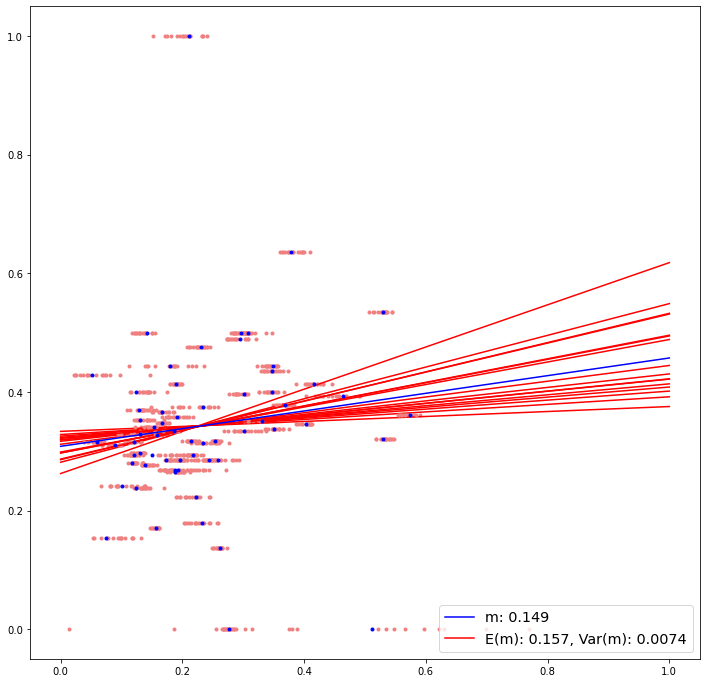

In [8]:
for county in ["Brazoria"]: #"Bell", "Galveston", "Brazoria", "Nueces", "Cameron"]:
    df = combine_csvs(five_counties_dir + "/" + county + "/", runoff_file, False, five_counties=True)
    plot_er_and_point_estimates(county, df, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False, fig_size=(12, 12))

In [ ]:
# make plots for Galveston City
# county = "Brazoria"
# df = combine_csvs(five_counties_dir + "/" + county + "/", runoff_file, False, five_counties=True)
# city = gpd.read_file("Small Counties/shapes/precincts/galveston_city_precincts.shp")
# galveston_city = df[df["Precinct"].isin(city["CNTYVTD"])]
# plot_er_and_point_estimates(county, galveston_city, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False, fig_size=(24, 6))

In [ ]:
galveston_city.head(16)

In [ ]:
toydown = pd.read_csv("new_recon_toydown_non_neg_dallas_county_prec_runs.csv")
toydown = toydown.rename(columns = {"CNTYVTD": "Precinct"})
small_df = df_without_hhs[["Precinct", "18R_Governor_D_tot", "ValdezD_18R_Governor_pct", "HVAP_pct"]].copy()
small_df = small_df.reset_index(drop=True)
small_df = small_df.head(len(small_df["Precinct"].unique()))
toydown = toydown.merge(small_df, on="Precinct", how="left")

toydown.loc[(toydown["split"] == "top_heavy"), "split"] = "top-heavy" 
toydown.loc[(toydown["split"] == "mid_heavy"), "split"] = "mid-heavy" 
toydown.loc[(toydown["split"] == "bottom_heavy"), "split"] = "bottom-heavy" 

toydown.loc[(toydown["epsilon"] == 0.25), "epsilon"] = "0.25"
toydown.loc[(toydown["epsilon"] == 0.5), "epsilon"] = "0.5"
toydown.loc[(toydown["epsilon"] == 1.), "epsilon"] = "1"
toydown.loc[(toydown["epsilon"] == 2.), "epsilon"] = "2"

epsilon_splits = ["equal", "bottom-heavy", "mid-heavy"]
toy_zeros, toy_ones, unnoised_zero, unnoised_one = plot_er_and_point_estimates("Dallas", toydown, epsilon_values, epsilon_splits, "HVAP", candidate_configs, with_hh=False, fig_size=(8, 6))

In [ ]:
zeros = np.append(top_zeros, toy_zeros)
ones = np.append(top_ones, toy_ones)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
race = "HVAP"
ax.hist(toy_zeros, color="mediumturquoise", alpha=0.5, label="all but {} support".format(race))
ax.hist(top_zeros, color="teal",  alpha=0.5, label="{} support".format(race))
ax.hist(toy_ones, color="gold", alpha=0.5, label="all but {} support".format(race))
ax.hist(top_ones, color="darkgoldenrod",  alpha=0.5, label="{} support".format(race))
ax.axvline(unnoised_zero, color="slategrey", linestyle="dashed")
ax.axvline(unnoised_one, color="slategrey", linestyle="dashed")
ax.set_xlim(0.4, 0.9)
ax.set_ylim(0, 15)
plt.savefig("equal_mid_bottom_1_superimposed_weighted.png", dpi=300, bbox_inches="tight")

In [ ]:
len(zeros)

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
race = "HVAP"
ax.hist(toy_zeros, color="limegreen", alpha=0.5, label="all but {} support".format(race))
ax.hist(top_zeros, color="mediumpurple",  alpha=0.5, label="{} support".format(race))
# ax.axvline(zeros.mean(), color="limegreen")
# ax.axvline(ones.mean(), color="mediumpurple")
ax.set_xlim(0.4, 0.9)
# plt.savefig("combined_squished.png", dpi=300, bbox_inches="tight")

In [ ]:
toy_zeros.mean()

In [ ]:
top_zeros.mean()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
race = "HVAP"
ax.hist(toy_ones, color="limegreen", alpha=0.5, label="all but {} support".format(race))
ax.hist(top_ones, color="mediumpurple",  alpha=0.5, label="{} support".format(race))
# ax.axvline(zeros.mean(), color="limegreen")
# ax.axvline(ones.mean(), color="mediumpurple")
ax.set_xlim(0.4, 0.9)

In [ ]:
toy_ones.mean()

In [ ]:
top_ones.mean()

In [ ]:
for county in ["Bell", "Galveston", "Brazoria", "Nueces", "Cameron"]:
    print(county)
    df = combine_csvs(five_counties_dir + "/" + county + "/", runoff_file, False, five_counties=True)
    df = df[df["split"] == "equal"]
    all_rows = len(df)
    filtered = len(df[df["18R_Governor_D_tot"] > 10])
    print("All: ", all_rows)
    print("After filtering: ", filtered)
    print("Num precincts dropped: ", all_rows - filtered)
    print()

In [ ]:
# make plots for Galveston City
county = "Galveston"
df = combine_csvs(five_counties_dir + "/" + county + "/", runoff_file, False, five_counties=True)
df = df[df["split"] == "equal"]
city = gpd.read_file("Small Counties/shapes/precincts/galveston_city_precincts.shp")
galveston_city = df[df["Precinct"].isin(city["CNTYVTD"])]
all_rows = len(galveston_city)
filtered = len(galveston_city[galveston_city["18R_Governor_D_tot"] > 10])
print("All: ", all_rows)
print("After filtering: ", filtered)
print("Num precincts dropped: ", all_rows - filtered)
print()

In [18]:
df = combine_csvs(five_counties_dir + "/" + "Bell" + "/", runoff_file, False, five_counties=True)
df

,Precinct,0_HISP_noise,1_HISP_noise,2_HISP_noise,3_HISP_noise,4_HISP_noise,5_HISP_noise,6_HISP_noise,7_HISP_noise,8_HISP_noise,9_HISP_noise,10_HISP_noise,11_HISP_noise,12_HISP_noise,13_HISP_noise,14_HISP_noise,15_HISP_noise,0_NHWHITE_noise,1_NHWHITE_noise,2_NHWHITE_noise,3_NHWHITE_noise,4_NHWHITE_noise,5_NHWHITE_noise,6_NHWHITE_noise,7_NHWHITE_noise,8_NHWHITE_noise,9_NHWHITE_noise,10_NHWHITE_noise,11_NHWHITE_noise,12_NHWHITE_noise,13_NHWHITE_noise,14_NHWHITE_noise,15_NHWHITE_noise,0_NHBLACK_noise,1_NHBLACK_noise,2_NHBLACK_noise,3_NHBLACK_noise,4_NHBLACK_noise,5_NHBLACK_noise,6_NHBLACK_noise,7_NHBLACK_noise,8_NHBLACK_noise,9_NHBLACK_noise,10_NHBLACK_noise,11_NHBLACK_noise,12_NHBLACK_noise,13_NHBLACK_noise,14_NHBLACK_noise,15_NHBLACK_noise,0_NHAMIN_noise,1_NHAMIN_noise,2_NHAMIN_noise,3_NHAMIN_noise,4_NHAMIN_noise,5_NHAMIN_noise,6_NHAMIN_noise,7_NHAMIN_noise,8_NHAMIN_noise,9_NHAMIN_noise,10_NHAMIN_noise,11_NHAMIN_noise,12_NHAMIN_noise,13_NHAMIN_noise,14_NHAMIN_noise,15_NHAMIN_noise,0_NHASIAN_noise,1_NHASIAN_noise,2_NHASIAN_noise,3_NHASIAN_noise,4_NHASIAN_noise,5_NHASIAN_noise,6_NHASIAN_noise,7_NHASIAN_noise,8_NHASIAN_noise,9_NHASIAN_noise,10_NHASIAN_noise,11_NHASIAN_noise,12_NHASIAN_noise,13_NHASIAN_noise,14_NHASIAN_noise,15_NHASIAN_noise,0_NHHAWAIIAN_noise,1_NHHAWAIIAN_noise,2_NHHAWAIIAN_noise,3_NHHAWAIIAN_noise,4_NHHAWAIIAN_noise,5_NHHAWAIIAN_noise,6_NHHAWAIIAN_noise,7_NHHAWAIIAN_noise,8_NHHAWAIIAN_noise,9_NHHAWAIIAN_noise,10_NHHAWAIIAN_noise,11_NHHAWAIIAN_noise,12_NHHAWAIIAN_noise,13_NHHAWAIIAN_noise,14_NHHAWAIIAN_noise,15_NHHAWAIIAN_noise,0_NHOTHER_noise,1_NHOTHER_noise,2_NHOTHER_noise,3_NHOTHER_noise,4_NHOTHER_noise,5_NHOTHER_noise,6_NHOTHER_noise,7_NHOTHER_noise,8_NHOTHER_noise,9_NHOTHER_noise,10_NHOTHER_noise,11_NHOTHER_noise,12_NHOTHER_noise,13_NHOTHER_noise,14_NHOTHER_noise,15_NHOTHER_noise,0_HVAP_noise,1_HVAP_noise,2_HVAP_noise,3_HVAP_noise,4_HVAP_noise,5_HVAP_noise,6_HVAP_noise,7_HVAP_noise,8_HVAP_noise,9_HVAP_noise,10_HVAP_noise,11_HVAP_noise,12_HVAP_noise,13_HVAP_noise,14_HVAP_noise,15_HVAP_noise,0_WVAP_noise,1_WVAP_noise,2_WVAP_noise,3_WVAP_noise,4_WVAP_noise,5_WVAP_noise,6_WVAP_noise,7_WVAP_noise,8_WVAP_noise,9_WVAP_noise,10_WVAP_noise,11_WVAP_noise,12_WVAP_noise,13_WVAP_noise,14_WVAP_noise,15_WVAP_noise,0_BVAP_noise,1_BVAP_noise,2_BVAP_noise,3_BVAP_noise,4_BVAP_noise,5_BVAP_noise,6_BVAP_noise,7_BVAP_noise,8_BVAP_noise,9_BVAP_noise,10_BVAP_noise,11_BVAP_noise,12_BVAP_noise,13_BVAP_noise,14_BVAP_noise,15_BVAP_noise,0_AMINVAP_noise,1_AMINVAP_noise,2_AMINVAP_noise,3_AMINVAP_noise,4_AMINVAP_noise,5_AMINVAP_noise,6_AMINVAP_noise,7_AMINVAP_noise,8_AMINVAP_noise,9_AMINVAP_noise,10_AMINVAP_noise,11_AMINVAP_noise,12_AMINVAP_noise,13_AMINVAP_noise,14_AMINVAP_noise,15_AMINVAP_noise,0_ASIANVAP_noise,1_ASIANVAP_noise,2_ASIANVAP_noise,3_ASIANVAP_noise,4_ASIANVAP_noise,5_ASIANVAP_noise,6_ASIANVAP_noise,7_ASIANVAP_noise,8_ASIANVAP_noise,9_ASIANVAP_noise,10_ASIANVAP_noise,11_ASIANVAP_noise,12_ASIANVAP_noise,13_ASIANVAP_noise,14_ASIANVAP_noise,15_ASIANVAP_noise,0_HAWAIIANVAP_noise,1_HAWAIIANVAP_noise,2_HAWAIIANVAP_noise,3_HAWAIIANVAP_noise,4_HAWAIIANVAP_noise,5_HAWAIIANVAP_noise,6_HAWAIIANVAP_noise,7_HAWAIIANVAP_noise,8_HAWAIIANVAP_noise,9_HAWAIIANVAP_noise,10_HAWAIIANVAP_noise,11_HAWAIIANVAP_noise,12_HAWAIIANVAP_noise,13_HAWAIIANVAP_noise,14_HAWAIIANVAP_noise,15_HAWAIIANVAP_noise,0_OTHERVAP_noise,1_OTHERVAP_noise,2_OTHERVAP_noise,3_OTHERVAP_noise,4_OTHERVAP_noise,5_OTHERVAP_noise,6_OTHERVAP_noise,7_OTHERVAP_noise,8_OTHERVAP_noise,9_OTHERVAP_noise,10_OTHERVAP_noise,11_OTHERVAP_noise,12_OTHERVAP_noise,13_OTHERVAP_noise,14_OTHERVAP_noise,15_OTHERVAP_noise,0_VAP_noise,1_VAP_noise,2_VAP_noise,3_VAP_noise,4_VAP_noise,5_VAP_noise,6_VAP_noise,7_VAP_noise,8_VAP_noise,9_VAP_noise,10_VAP_noise,11_VAP_noise,12_VAP_noise,13_VAP_noise,14_VAP_noise,15_VAP_noise,split,epsilon,Unnamed: 0,CNTYVTD,18R_Governor_D_tot,ValdezD_18R_Governor_pct,WhiteD_18R_Governor_pct,WVAP_pct,HVAP_pct,BVAP_pct,non_WVAP_pct,non_HVAP_pct,non_BVAP_pct
0,270101,1368.0,1236.

In [30]:
df = gpd.read_file("Small Counties/shapes/blocks/bell_county_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

310235
67010
41675
222118
0.1876254963577918


In [31]:
df = gpd.read_file("Small Counties/shapes/blocks/brazoria_county_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

313166
86643
55099
226181
0.24360578474761363


In [32]:
df = gpd.read_file("Small Counties/shapes/blocks/cameron_county_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

406220
357747
231515
272021
0.8510923788972174


In [33]:
df = gpd.read_file("Small Counties/shapes/blocks/galveston_county_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

291309
65270
42649
217142
0.19641064372622524


In [34]:
df = gpd.read_file("Small Counties/shapes/blocks/nueces_county_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

340223
206293
142995
251968
0.5675125412750825


In [35]:
df = gpd.read_file("Small Counties/shapes/blocks/galveston_city_blocks_2010_data.shp")
print(df["TOTPOP"].sum())
print(df["HISP"].sum())
print(df["HVAP"].sum())
print(df["VAP"].sum())
print(df["HVAP"].sum() / df["VAP"].sum())

47743
14925
10668
38516
0.2769758022639942
